# Feedforward Neural Network on the Iris Dataset

Fisher's Iris dataset  

This dataset contains 150 samples, with 4 dimensions, as follows:

1. Petal Length  (c1)
2. Petal Width   (c2)
3. Sepal Length  (c3)
4. Sepal Width   (c4)

There are 3 output classes: Setosa, Versicolor, and Virginica.
In our output datset, we have simplified this data by making classes simply 1, 2, 3.

Here's an example of what the dataset looks like

| c1  | c2  | c3  | c4  | label | 
|-----|-----|-----|-----|-------| 
| 6.4 | 2.8 | 5.6 | 2.2 | 3     | 
| 5.0 | 2.3 | 3.3 | 1.0 | 2     | 
| 4.9 | 2.5 | 4.5 | 1.7 | 3     | 
| 4.9 | 3.1 | 1.5 | 0.1 | 1     | 
| 5.7 | 3.8 | 1.7 | 0.3 | 1     | 
| 4.4 | 3.2 | 1.3 | 0.2 | 1     | 
| 5.4 | 3.4 | 1.5 | 0.4 | 1     | 
| 6.9 | 3.1 | 5.1 | 2.3 | 3     | 
| 6.7 | 3.1 | 4.4 | 1.4 | 2     | 


In [1]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc


import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt

from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *

from pyspark.sql.functions import col

LABELS = ["Setosa", "Virginica", "Versicolor"]


init_engine()

## Parameters

These are parameters that can be changed:

Explanation:

1. Learning Rate:  This indicates the "step size" of the gradient descent-type optimization functions. The larger the step size, the less of a chance of getting caught in a local minimum but too large may lead to very poor results.

2. Training Epochs: the number of cycles of training that we use.

3. Batch size: The size of the batch (with replacement) that we take per training iteration.

4. N_input: Number of input dimensions

5. N_Classes: Number of output classes for classification problem.

6. N_Hidden_1: Number of hidden layer neurons.

In [2]:
learning_rate = 0.1
training_epochs = 20
batch_size = 16
display_step = 1

# Network Parameters
n_input = 4   # Number of input dimensions
n_classes = 3  # Number of output classes (Setosa, Virginica, Versicolor)
n_hidden_1 = 3 # Hidden layer number of features


## A Simple Neural Network

Here's a picture of a simple neural network, like what we have in this example:

<img src="../images/Feed_forward_neural_net.gif">

As you can see, we have a total of 3 layers:

1. Input layer (sized as number of features -- in this case 4)
2. Hidden Layer (size we have to specify as part of the model).
3. Output Layer (Number of output classes we are trying to classify -- in this case 3)



### Sizing the Hidden Layer(s)

Sizing hidden layers can be a challenge.  The best way to figure this out is to do it
empirically.  However, we may need a "rule of thumb" to start.  Here is a good rule of thumb:

First Hidden Layer:
```
n_hidden_1 = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
```

Second Hidden Layer:  (if needed)
```
n_hidden_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
```

In this case, we have a **VERY** simple dataset.  We may not need two hidden layers. Let's see what we have.

In [18]:
# Number of hidden layers

n_hidden_guess = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
print("Hidden layer 1 (Guess) : " + str(n_hidden_guess))

n_hidden_guess_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
print("Hidden layer 2 (Guess) : " + str(n_hidden_guess_2))


Hidden layer 1 (Guess) : 2.50219710195
Hidden layer 2 (Guess) : 2.683281573


## Loading the Data

Let's use Spark Dataframes to load the data. We can take advantage of the header and infer the schema.

In [4]:
iris_training = spark.read.csv("../data/iris/iris_training.csv", header=True, inferSchema="true", mode="DROPMALFORMED")
iris_test = spark.read.csv("../data/iris/iris_test.csv", header=True, inferSchema="true", mode="DROPMALFORMED")

#Force everything to be of type double
iris_training = iris_training.select([col(c).cast("double") for c in iris_training.columns])
iris_test = iris_test.select([col(c).cast("double") for c in iris_test.columns])



In [5]:
iris_k_train = iris_training.rdd.map(list)
iris_k_test = iris_test.rdd.map(list)

## Examine Training and Validation Class Distribution

Let's look at the training class distribution. Are the different input classes relatively balanced?

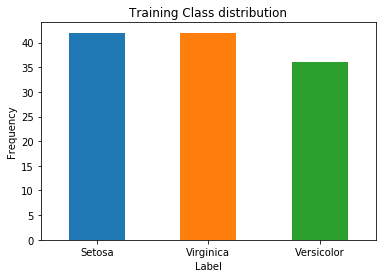

In [6]:
count_classes = pd.value_counts(iris_training.select('label').toPandas()['label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Training Class distribution")
plt.xticks(range(n_classes), LABELS)
plt.xlabel("Label")
plt.ylabel("Frequency");

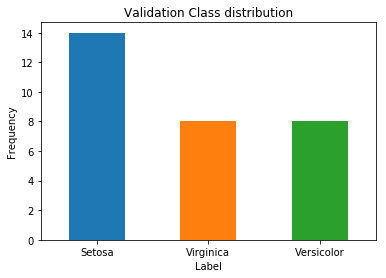

In [7]:
count_classes = pd.value_counts(iris_test.select('label').toPandas()['label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Validation Class distribution")
plt.xticks(range(n_classes), LABELS)
plt.xlabel("Label")
plt.ylabel("Frequency");

### Examining the Data

Let's eyeball the data and see what it looks like.


In [8]:
iris_k_train.take(29)

[[6.4, 2.8, 5.6, 2.2, 3.0],
 [5.0, 2.3, 3.3, 1.0, 2.0],
 [4.9, 2.5, 4.5, 1.7, 3.0],
 [4.9, 3.1, 1.5, 0.1, 1.0],
 [5.7, 3.8, 1.7, 0.3, 1.0],
 [4.4, 3.2, 1.3, 0.2, 1.0],
 [5.4, 3.4, 1.5, 0.4, 1.0],
 [6.9, 3.1, 5.1, 2.3, 3.0],
 [6.7, 3.1, 4.4, 1.4, 2.0],
 [5.1, 3.7, 1.5, 0.4, 1.0],
 [5.2, 2.7, 3.9, 1.4, 2.0],
 [6.9, 3.1, 4.9, 1.5, 2.0],
 [5.8, 4.0, 1.2, 0.2, 1.0],
 [5.4, 3.9, 1.7, 0.4, 1.0],
 [7.7, 3.8, 6.7, 2.2, 3.0],
 [6.3, 3.3, 4.7, 1.6, 2.0],
 [6.8, 3.2, 5.9, 2.3, 3.0],
 [7.6, 3.0, 6.6, 2.1, 3.0],
 [6.4, 3.2, 5.3, 2.3, 3.0],
 [5.7, 4.4, 1.5, 0.4, 1.0],
 [6.7, 3.3, 5.7, 2.1, 3.0],
 [6.4, 2.8, 5.6, 2.1, 3.0],
 [5.4, 3.9, 1.3, 0.4, 1.0],
 [6.1, 2.6, 5.6, 1.4, 3.0],
 [7.2, 3.0, 5.8, 1.6, 3.0],
 [5.2, 3.5, 1.5, 0.2, 1.0],
 [5.8, 2.6, 4.0, 1.2, 2.0],
 [5.9, 3.0, 5.1, 1.8, 3.0],
 [5.4, 3.0, 4.5, 1.5, 2.0]]

### Converting to RDD of Sample

BigDL requires all input data to be in its native Sample format (for the RDD API).  The Pipeline api, shown in feedforward-iris-pipeline -- allows data to be in Spark Dataframes.

To convert the data into type Sample, we will use a helper method here to convert. The sample function requires two numpy arrays:

1. Feature array (of all the features in double type)
2. Label array: the label value (usually just a single number in the array).

Then we convert these to RDDs of type Sample.

In [9]:
#convert ndarray data into RDD[Sample]
def array2rdd(ds):
    #build Sample from ndarrays
    def build_sample(c0,c1,c2,c3,prediction):
        feature = np.array([c0,c1, c2, c3]).flatten()
        label = np.array(prediction)
        return Sample.from_ndarray(feature, label)
    rdd = ds.map(lambda (c0,c1,c2,c3,prediction): build_sample(c0,c1,c2,c3,prediction))
    return rdd

iris_rdd_train = array2rdd(iris_k_train)
iris_rdd_train.cache()
print("Training Count: " + str(iris_rdd_train.count()))

iris_rdd_test = array2rdd(iris_k_test)
iris_rdd_test.cache()
print ("Test Count: " + str(iris_rdd_test.count()))

Training Count: 120
Test Count: 30


## Setting up our network

Here we are going to actually set up our network.  It will be single hidden layer network, with input layer (based on our 4-inputs), and output layer (softmax with 3 classes).  

The hidden layer has been set up to 3, and we will use ReLU activation for that hidden layer. ReLU is currently preferred as a activation layer for these types of networks as it is linear in the postive direction, avoiding the vanishing gradient problem.


In [10]:
# Create model

def multilayer_perceptron(n_hidden_1, n_input, n_classes):
    # Initialize a sequential container
    model = Sequential()
    # Hidden layer with ReLu activation
    model.add(Linear(n_input, n_hidden_1).set_name('mlp_fc1'))
    model.add(ReLU())
    # output layer
    model.add(Linear(n_hidden_1, n_classes).set_name('mlp_fc4'))
    model.add(LogSoftMax())
    return model

model = multilayer_perceptron(n_hidden_1, n_input, n_classes)

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


### Training the Model

Now we need to set up our training. We are going to use the following:

* Loss Function: ClassNLLCriterion
* Optimization: AdaGrad 

For validation, we will validating against top1Accuracy for every epoch.

In [11]:
# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=iris_rdd_train,
    criterion=ClassNLLCriterion(),
    optim_method=Adagrad(learningrate=learning_rate, learningrate_decay=0.0002),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=iris_rdd_test,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='iris-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createAdagrad
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
('saving logs to ', 'iris-20171205-221139')


In [12]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 0 ns, sys: 20 ms, total: 20 ms
Wall time: 11.4 s


## Let's look at the training graphs

We're going to plot the Loss and Top1 Accuracy by iteration to see how our training went.

Note there are two graphs: Loss, and top1 Accuracy

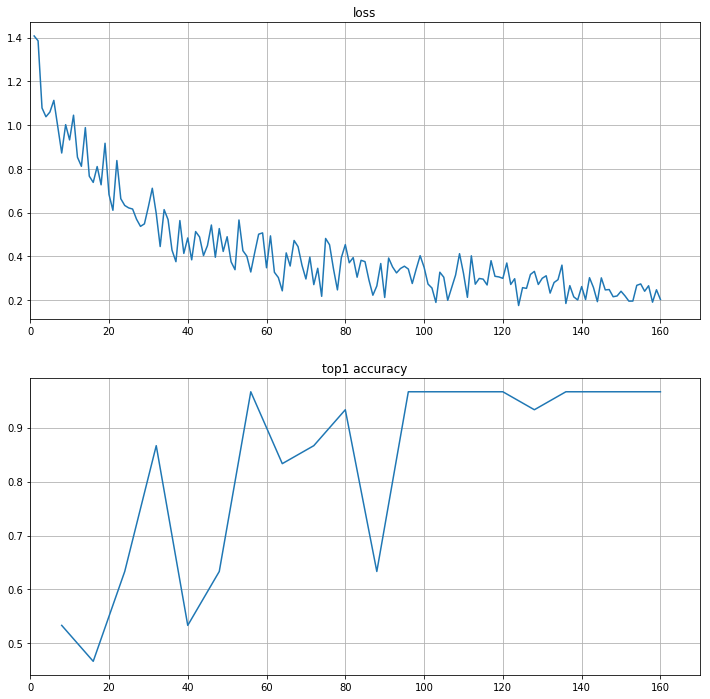

In [13]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)


## See visualizations on tensorboard as well

We can run tensorboard at the command prompt and see visualizations too -- much prettier ones in fact than is available here.

To do, run at the command line:

$ tensorboard --logdir="/tmp/bigdl_summaries"

And then, you can go to your browser:

http://YOURHOSTNAME:6006

## Show Confusion Matrix and Accuracy score on Validation Data

Here, we are going to run predictions on our validation data to determine our accuracy on validation data and our confusion matrix.

Nobody really cares what our error (loss) is on training data.  It's validation data that really matters.  So, calculating accuracy.

As Iris is a 3-class output, we will be doing a confusion matrix to see how that went.

In [14]:
predictions = trained_model.predict(iris_rdd_test).collect()

def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l.to_ndarray()[0] - 1

y_pred = np.array([ map_predict_label(s) for s in predictions])

y_true = np.array([map_groundtruth_label(s.label) for s in iris_rdd_test.collect()])

The prediction accuracy is 83.33%


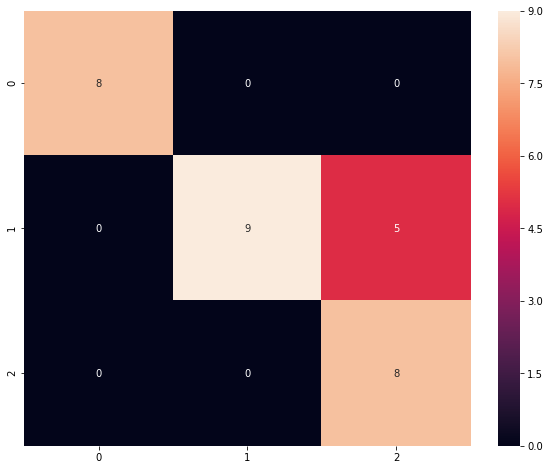

In [15]:
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');

In [16]:
def map_predict_label(outputs, threshold):
    p = map(lambda x: np.exp(x), outputs)
    if (np.max(p) < threshold):
        return len(outputs) + 1
    return np.argmax(outputs) + 1
    

In [17]:
true_positive_rate = list()
false_positive_rate = list()
 
for threshold in np.linspace(0.0, 1.0, num = 100):
    y_pred = np.array([map_predict_label(s, threshold) for s in predictions])
 